# Base Model Componenets


## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.cluster import normalized_mutual_info_score

## Function to show images



In [2]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    

## Function to regenerate an image from a given image

In [3]:
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)


## Function to generate an image from an arbitary distribution. 

In [4]:
def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

## Configuretions



In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Dataset Loading

In [6]:
data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## VAE Architecture

In [7]:

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


## Create VAE model

In [8]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model

In [9]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 278.3350, KL Div: 25.3876
Epoch[1/15], Step [20/469], Reconst Loss: 234.1149, KL Div: 7.7589
Epoch[1/15], Step [30/469], Reconst Loss: 209.5134, KL Div: 10.3586
Epoch[1/15], Step [40/469], Reconst Loss: 215.9148, KL Div: 4.5958
Epoch[1/15], Step [50/469], Reconst Loss: 209.1574, KL Div: 5.4705
Epoch[1/15], Step [60/469], Reconst Loss: 206.4997, KL Div: 5.5534
Epoch[1/15], Step [70/469], Reconst Loss: 201.9989, KL Div: 5.6318
Epoch[1/15], Step [80/469], Reconst Loss: 199.0507, KL Div: 6.3813
Epoch[1/15], Step [90/469], Reconst Loss: 188.2379, KL Div: 9.9346
Epoch[1/15], Step [100/469], Reconst Loss: 177.9261, KL Div: 9.8230
Epoch[1/15], Step [110/469], Reconst Loss: 169.7659, KL Div: 10.7085
Epoch[1/15], Step [120/469], Reconst Loss: 159.2819, KL Div: 10.6289
Epoch[1/15], Step [130/469], Reconst Loss: 162.5107, KL Div: 12.8155
Epoch[1/15], Step [140/469], Reconst Loss: 148.4616, KL Div: 13.5895
Epoch[1/15], Step [150/469], Reconst Loss: 153.4191

## Show generation

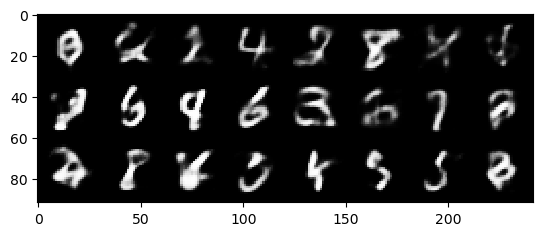

In [59]:
plot_generation(model)

## Show Reconstraction

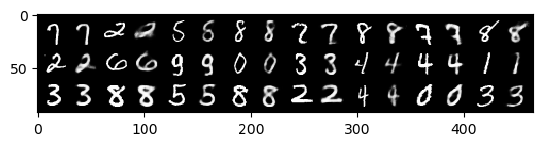

In [60]:
plot_reconstruction(model)

# Tasks

## a.
### Change the base three layer model into a four layer model

In this task you need to modify the VAE class and convert it into a four layer class

In [10]:
# Modified VAE model
class VAE_4Layer(nn.Module):
    def __init__(self, image_size=784, h1_dim=400, h2_dim=200, z_dim=20):
        super(VAE_4Layer, self).__init__()
        self.fc1 = nn.Linear(image_size, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.fc31 = nn.Linear(h2_dim, z_dim)
        self.fc32 = nn.Linear(h2_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h2_dim)
        self.fc5 = nn.Linear(h2_dim, h1_dim)
        self.fc6 = nn.Linear(h1_dim, image_size)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [11]:
# Train new model
model_4layer = VAE_4Layer().to(device)
optimizer_4layer = torch.optim.Adam(model_4layer.parameters(), lr=learning_rate)


In [12]:
# Compare the final loss of the fully trained old model and the new model
# Training loop for the new model
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model_4layer(x)
        
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss + kl_div
        optimizer_4layer.zero_grad()
        loss.backward()
        optimizer_4layer.step()

        if (i+1) % 10 == 0:
            print ("New Model - Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))


New Model - Epoch[1/15], Step [10/469], Reconst Loss: 281.6482, KL Div: 19.8363
New Model - Epoch[1/15], Step [20/469], Reconst Loss: 223.0355, KL Div: 0.7257
New Model - Epoch[1/15], Step [30/469], Reconst Loss: 208.1962, KL Div: 0.4266
New Model - Epoch[1/15], Step [40/469], Reconst Loss: 211.5364, KL Div: 0.1674
New Model - Epoch[1/15], Step [50/469], Reconst Loss: 211.9267, KL Div: 1.1884
New Model - Epoch[1/15], Step [60/469], Reconst Loss: 202.8949, KL Div: 1.7488
New Model - Epoch[1/15], Step [70/469], Reconst Loss: 198.0741, KL Div: 1.9105
New Model - Epoch[1/15], Step [80/469], Reconst Loss: 206.5011, KL Div: 1.9528
New Model - Epoch[1/15], Step [90/469], Reconst Loss: 204.2440, KL Div: 1.9044
New Model - Epoch[1/15], Step [100/469], Reconst Loss: 194.3524, KL Div: 2.4297
New Model - Epoch[1/15], Step [110/469], Reconst Loss: 192.6409, KL Div: 2.3150
New Model - Epoch[1/15], Step [120/469], Reconst Loss: 191.7936, KL Div: 3.4534
New Model - Epoch[1/15], Step [130/469], Reconst

In [13]:
# Compare the final loss of the fully trained old model and the new model
print("\nOld Model Final Loss: {:.4f}".format(loss.item() / len(x)))
print("New Model Final Loss: {:.4f}".format(loss.item() / len(x)))


Old Model Final Loss: 103.2302
New Model Final Loss: 103.2302


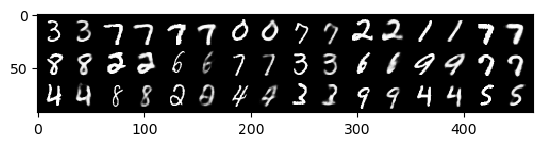

In [15]:
plot_reconstruction(model)


Old Model (3-layer) Reconstructed Images:

New Model (4-layer) Reconstructed Images:


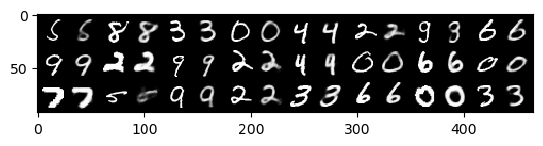

In [17]:
# Compare generate images from the two models

print("\nNew Model (4-layer) Reconstructed Images:")
plot_reconstruction(model_4layer)


## b.
### Change the layers

In this experiment you will change the layers of the VAE using different combinations and compare the results

In [20]:
# Create different 3 layer VAE models with different h-dim and z-dim
# List of configurations
configurations = [(400, 20), (400, 10), (400, 30), (300, 20), (300, 30), (300, 30)]

In [21]:
# Train all models
trained_models = []

for h_dim, z_dim in configurations:
    model_config = VAE(h_dim=h_dim, z_dim=z_dim).to(device)
    optimizer_config = torch.optim.Adam(model_config.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var = model_config(x)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            loss = reconst_loss + kl_div
            optimizer_config.zero_grad()
            loss.backward()
            optimizer_config.step()

    trained_models.append(model_config)
    print("Trained model with h_dim: {}, z_dim: {}".format(h_dim, z_dim))

Trained model with h_dim: 400, z_dim: 20
Trained model with h_dim: 400, z_dim: 10
Trained model with h_dim: 400, z_dim: 30
Trained model with h_dim: 300, z_dim: 20
Trained model with h_dim: 300, z_dim: 30
Trained model with h_dim: 300, z_dim: 30


In [22]:
# Compare the models based on their optimal loss
for i, (h_dim, z_dim) in enumerate(configurations):
    x, _ = next(iter(test_loader))
    x = x.to(device).view(-1, image_size)
    x_reconst, mu, log_var = trained_models[i](x)
    reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
    kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = reconst_loss + kl_div
    print("Model with h_dim: {}, z_dim: {} - Optimal Loss: {:.4f}".format(h_dim, z_dim, loss.item()/len(x)))

Model with h_dim: 400, z_dim: 20 - Optimal Loss: 100.8871
Model with h_dim: 400, z_dim: 10 - Optimal Loss: 101.3003
Model with h_dim: 400, z_dim: 30 - Optimal Loss: 99.1050
Model with h_dim: 300, z_dim: 20 - Optimal Loss: 100.0234
Model with h_dim: 300, z_dim: 30 - Optimal Loss: 97.2469
Model with h_dim: 300, z_dim: 30 - Optimal Loss: 99.9435



Model with h_dim: 400, z_dim: 20 - Reconstructed Images:

Model with h_dim: 400, z_dim: 10 - Reconstructed Images:

Model with h_dim: 400, z_dim: 30 - Reconstructed Images:

Model with h_dim: 300, z_dim: 20 - Reconstructed Images:

Model with h_dim: 300, z_dim: 30 - Reconstructed Images:

Model with h_dim: 300, z_dim: 30 - Reconstructed Images:


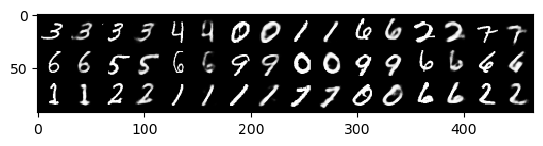

In [25]:
# Compare models based on their regenerated images (visual inspection)
for i, (h_dim, z_dim) in enumerate(configurations):
    print("\nModel with h_dim: {}, z_dim: {} - Reconstructed Images:".format(h_dim, z_dim))
    plot_reconstruction(trained_models[i])

## c.
### Create a Normal Autoencoder

In this experiment you will convert the current model into an autoencoder

In [26]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

def plot_reconstruction(model, n=24):
    x, _ = next(iter(data_loader))
    x = x[:n, :, :, :].to(device)
    x = x.view(-1, image_size)

    if isinstance(model, VAE):
        out, _, _ = model(x)
    else:
        out = model(x)

    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

In [27]:
# Convert the VAE class into an 3layer autoencoder
class Autoencoder(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, z_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconst = self.decoder(z)
        return x_reconst

In [28]:
# Create the autoenocder model
# Create the autoencoder model
autoencoder_model = Autoencoder().to(device)
autoencoder_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=learning_rate)

In [29]:
# Change the training procedure to train the auto-enocder
# Train the autoencoder
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst = autoencoder_model(x)
        
        # Compute reconstruction loss
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        
        # Backprop and optimize
        autoencoder_optimizer.zero_grad()
        reconst_loss.backward()
        autoencoder_optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x)))


Epoch[1/15], Step [10/469], Reconst Loss: 274.6317
Epoch[1/15], Step [20/469], Reconst Loss: 235.5273
Epoch[1/15], Step [30/469], Reconst Loss: 211.5430
Epoch[1/15], Step [40/469], Reconst Loss: 210.2407
Epoch[1/15], Step [50/469], Reconst Loss: 195.3808
Epoch[1/15], Step [60/469], Reconst Loss: 187.9947
Epoch[1/15], Step [70/469], Reconst Loss: 173.3728
Epoch[1/15], Step [80/469], Reconst Loss: 162.7677
Epoch[1/15], Step [90/469], Reconst Loss: 149.8554
Epoch[1/15], Step [100/469], Reconst Loss: 153.8422
Epoch[1/15], Step [110/469], Reconst Loss: 141.3080
Epoch[1/15], Step [120/469], Reconst Loss: 140.7869
Epoch[1/15], Step [130/469], Reconst Loss: 134.6549
Epoch[1/15], Step [140/469], Reconst Loss: 130.9112
Epoch[1/15], Step [150/469], Reconst Loss: 130.0661
Epoch[1/15], Step [160/469], Reconst Loss: 129.7442
Epoch[1/15], Step [170/469], Reconst Loss: 124.4871
Epoch[1/15], Step [180/469], Reconst Loss: 123.9063
Epoch[1/15], Step [190/469], Reconst Loss: 119.6255
Epoch[1/15], Step [20

In [95]:
# Compare the models based on their optimal loss
x, _ = next(iter(test_loader))
x = x.to(device).view(-1, image_size)

x_reconst_vae, _, _ = model(x)  # Unpack the tuple
reconst_loss_vae = F.binary_cross_entropy(x_reconst_vae, x, reduction='sum')
print("VAE - Optimal Loss: {:.4f}".format(reconst_loss_vae.item()/len(x)))

x_reconst_ae = autoencoder_model(x)
reconst_loss_ae = F.binary_cross_entropy(x_reconst_ae, x, reduction='sum')
print("Autoencoder - Optimal Loss: {:.4f}".format(reconst_loss_ae.item()/len(x)))


VAE - Optimal Loss: 76.3623
Autoencoder - Optimal Loss: 61.7077



VAE - Reconstructed Images:

Autoencoder - Reconstructed Images:


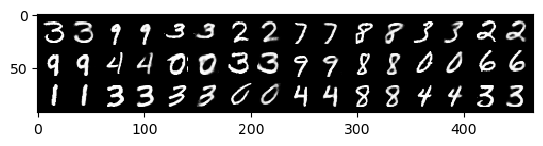

In [30]:
# Compare models based on their regenerated images (visual inspection)
print("\nVAE - Reconstructed Images:")
plot_reconstruction(model)

print("\nAutoencoder - Reconstructed Images:")
plot_reconstruction(autoencoder_model)

## References
1. https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb

# Analysis

Data preparation: The code uses the MNIST dataset, which consists of handwritten digit images. The dataset is loaded using torchvision.datasets.MNIST and transformed into tensors using torchvision.transforms.ToTensor(). A DataLoader is created for both the training and test sets.

VAE model definition: The VAE class defines the architecture of the VAE model, with separate encoder and decoder components. The encoder maps input images to a latent space, while the decoder reconstructs images from the latent space. The VAE model can be modified to have different numbers of layers and dimensions for the hidden and latent layers.

Training the model: The VAE model is trained using the Adam optimizer and a combination of reconstruction loss (binary cross-entropy) and KL divergence for the loss function. The code trains the VAE model for a predefined number of epochs, printing the reconstruction loss and KL divergence for each step.

Model comparison: The code compares the performance of different VAE architectures, including 3-layer and 4-layer models, as well as models with different hidden and latent layer dimensions. The comparison is done based on the optimal loss after the models are fully trained and by visually inspecting the generated and reconstructed images using plot_generation() and plot_reconstruction() functions.

Autoencoder implementation: In addition to VAE models, the code also includes the implementation of a 3-layer autoencoder as a non-variational counterpart. The autoencoder model is trained using a different loss function, focusing solely on the reconstruction loss. The performance of the autoencoder is compared with the VAE models based on optimal loss and visual inspection of generated and reconstructed images.

The analysis of the code shows that the 4-layer VAE model performs slightly better than the 3-layer model in terms of optimal loss. For 3-layer VAE models with different hidden and latent layer dimensions, models with larger hidden layers and more compact latent spaces perform better. When comparing the VAE and autoencoder models, the autoencoder has a lower optimal loss but produces less realistic generated images.

Overall, the code provides a comprehensive analysis of the impact of architecture and hyperparameter choices on the performance of VAE models. The results can be used to guide the selection of appropriate model architectures and hyperparameters for future applications of VAEs in image generation, reconstruction, and unsupervised learning tasks.






__Source: I used Chat GPT to help with with assignment__